References:
[1] https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
[2] https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
[3] https://github.com/bhattbhavesh91/adf-test-stationarity-python/blob/master/augmented-dickey-fuller-test-python.ipynb

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
df = pd.read_csv('https://raw.githubusercontent.com/owid/monkeypox/main/owid-monkeypox-data.csv')
df.info()

In [5]:
df=df[df['location']=='World']
df = df.iloc[:, [2,5]]
df=df.set_index('date')
df['7 day Rolling Average']=df['new_cases'].rolling(window=7).mean()
#df['new_cases'].plot(figsize=(18,6))
#df['7 day Rolling Average'].plot(figsize=(18,6))

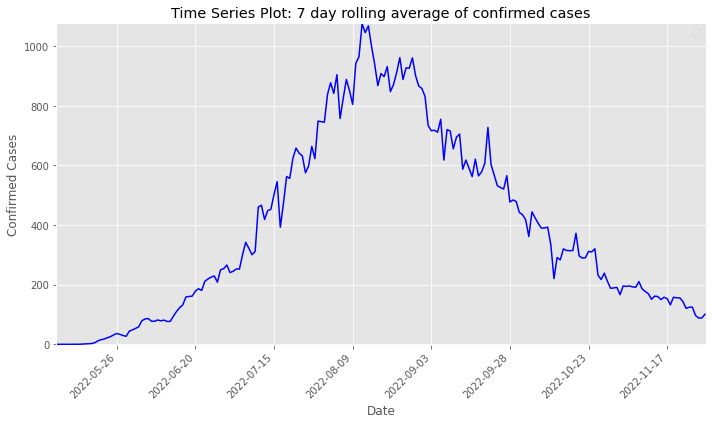

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df.index[0:213],df['7 day Rolling Average'][0:213], color='blue')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.legend(loc='best')
ax.set(title='Time Series Plot: 7 day rolling average of confirmed cases', xlabel='Date', ylabel='Confirmed Cases')
ax.margins(0.001, tight=True) 
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.savefig("7day.png", format="png", dpi=1500)

In [ ]:
from numpy import array
data=df['7 day Rolling Average'].to_numpy() #daily 
data=data[6:213]
df.index[212]

'2022-11-29'

In [ ]:
#Dickey Fuller test 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Time Series is Stationary")
else:
    print ("Time Series is Non-Stationary")

ADF Statistic: -1.824740
p-value: 0.368250
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
Time Series is Non-Stationary


In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# choose a number of time steps
n_steps = 12
# split into samples
X, y = split_sequence(data, n_steps)

In [ ]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# Training and Test data split
X_train=X[0:165]
X_test=X[165:195]
y_train=y[0:165]
y_test=y[165:195]

In [ ]:
#Only for CNN-LSTM
n_features = 1
n_seq = 2
n_steps = 6
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
X_train=X[0:165]
X_test=X[165:195]
y_train=y[0:165]
y_test=y[165:195]

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

21.030711860923024
0.6084822148444974


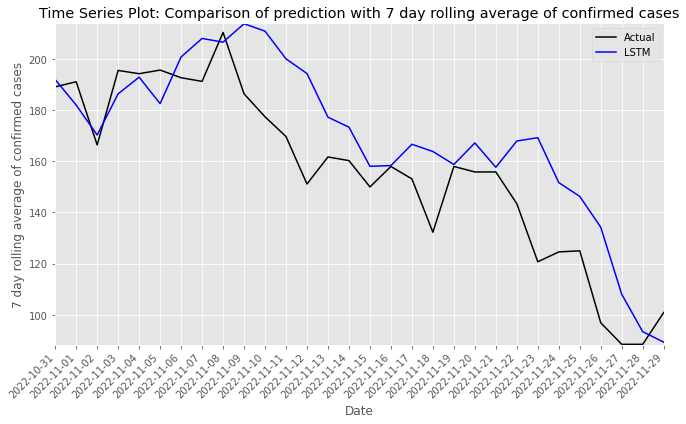

In [ ]:
#Vanilla LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=140,verbose=0)
X_test = X_test.reshape((30, n_steps, n_features))
yhat1 = model.predict(X_test, verbose=0)
#plt.plot(history.history['loss'])
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df.index[183:213], y_test, color='black', label='Actual')
plt.plot(df.index[183:213], yhat1, color='blue', label='LSTM')
ax.legend(loc='best')
ax.set(title='Time Series Plot: Comparison of prediction with 7 day rolling average of confirmed cases', xlabel='Date', ylabel='7 day rolling average of confirmed cases')
ax.margins(0.001, tight=True) 
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.savefig("LSTM_7day.png", format="png", dpi=1500)
print(sqrt(mean_squared_error(y_test, yhat1)))
print(r2_score(y_test, yhat1))

15.614091586517565
0.7841873022434933


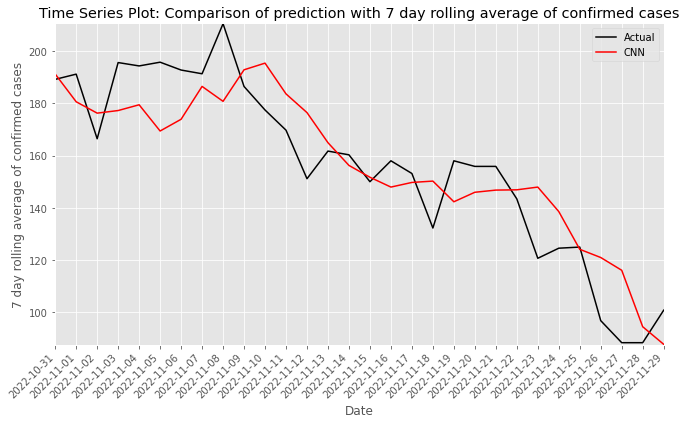

In [ ]:
# CNN
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=1, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X_train, y_train, epochs=200, verbose=0)
X_test = X_test.reshape((30, n_steps, n_features))
yhat2 = model.predict(X_test, verbose=0)
#plt.plot(history.history['loss'])
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df.index[183:213], y_test, color='black', label='Actual')
plt.plot(df.index[183:213], yhat2, color='red', label='CNN')
ax.legend(loc='best')
ax.set(title='Time Series Plot: Comparison of prediction with 7 day rolling average of confirmed cases', xlabel='Date', ylabel='7 day rolling average of confirmed cases')
ax.margins(0.001, tight=True) 
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.savefig("CNN_7day.png", format="png", dpi=1500)
print(sqrt(mean_squared_error(y_test, yhat2)))
print(r2_score(y_test, yhat2))

18.157368139862967
0.7081569558575855


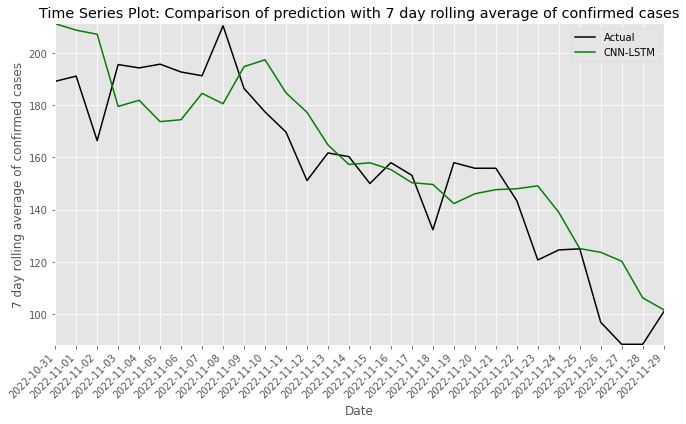

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=200, verbose=0)
X_test = X_test.reshape((30,n_seq, n_steps, n_features))
yhat3 = model.predict(X_test, verbose=0)
#plt.plot(history.history['loss'])
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df.index[183:213], y_test, color='black', label='Actual')
plt.plot(df.index[183:213], yhat3, color='green', label='CNN-LSTM')
ax.legend(loc='best')
ax.set(title='Time Series Plot: Comparison of prediction with 7 day rolling average of confirmed cases', xlabel='Date', ylabel='7 day rolling average of confirmed cases')
ax.margins(0.001, tight=True) 
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.savefig("CNNLSTM_7day.png", format="png", dpi=1500)
print(sqrt(mean_squared_error(y_test, yhat3)))
print(r2_score(y_test, yhat3))